We will need to analyse the data using seaborn and matplotlib to visualise some main areas.
    -missing data
    -duplicates
    -any strange variables and outliers
    -formats of data

we will use these options to visualise the areas we have listed. 
    -visually check the data to see if there are any missing values
    -check the names against eachother to see if there are any duplicates 
    -use a boxplot to check for outliers and to see if the datasets have a squew
    -check the units of the columns are equal 


visual analysis 

we can see that missing data is left blank. this makes our checks for data easy however there are multiple rows that have more then one missing pieces of data these will have to be analised and a descision will have to be made on what to do with these pieces of data.



In [52]:
#main imports of the general modules
import xlsxwriter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

now we will import the datasets 


In [53]:

od = pd.read_excel("od.xlsx")
os = pd.read_excel("os.xlsx")




In [54]:

new_columns = od.iloc[0].to_numpy()

os = os.iloc[1:].reset_index(drop=True)
od = od.iloc[1:].reset_index(drop=True)
os.columns = new_columns
od.columns = new_columns

od['eye'] = 'right'
os['eye'] = 'left'

combined_df = pd.concat([od,os], ignore_index=True)



In [55]:
print(od)

       ID Age  Gender   Diagnosis dioptre_1 dioptre_2 astigmatism   
0    #280  60    male     healthy      -0.5        -1          23  \
1    #198  67    male     healthy       0.5     -0.75         156   
2    #041  50  female  suspicious      1.75      -0.5         120   
3    #271  41    male     healthy     -1.25      -0.5         150   
4    #055  77  female    glaucoma         4        -2         102   
..    ...  ..     ...         ...       ...       ...         ...   
238  #089  65  female  suspicious        -6     -0.25          10   
239  #264  61    male  suspicious         2     -0.75          90   
240  #056  65    male    glaucoma        -1     -2.75         100   
241  #018  43    male  suspicious        -2     -0.75          97   
242  #174  63  female     healthy     -3.25      -0.5          72   

    Phakic/Pseudophakic                           Pneumatic Perkins   
0                   577              the eye keeps the lens      19  \
1                   486  crys

In [56]:
print(os)


       ID Age  Gender   Diagnosis dioptre_1 dioptre_2 astigmatism   
0    #002  47    male  suspicious      -0.5      -1.5          88  \
1    #004  58  female    glaucoma       1.5      -2.5          85   
2    #005  89  female    glaucoma      -0.5        -2         100   
3    #006  69    male  suspicious         1      -1.5          85   
4    #007  22  female  suspicious     -0.25      -0.5           0   
..    ...  ..     ...         ...       ...       ...         ...   
239  #289  64    male     healthY      0.75      -1.5          93   
240  #290  75  female     healthy      0.25     -0.25         160   
241  #291  55    male     healthy       1.5     -1.25          76   
242  #292  56  female     healthy      1.25     -0.75          79   
243  #293  39  female     healthy     -0.75     -0.25         110   

                    Phakic/Pseudophakic Pneumatic Perkins Pachymetry   
0                the eye keeps the lens        20     NaN        603  \
1    crystalline lens has b

let's remove the duplicates using the drop_duplicates from pandas

In [57]:
combined_df.drop_duplicates(inplace=True)



Now let's check the missing data and check for any columns with large amounts missing

--------------------------------------------------------------start of data analysis--------------------------------------------------------

In [58]:

def missing_data_counter(df):
    missing_number = df.isna().sum()
    num_rows = df.shape[0]
    
    for i in df.columns:
        
        print(f"{i}'s percentage of missing values is: {100*(missing_number[i]/num_rows)}")
    print('\n\n')
missing_data_counter(combined_df)


    







ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 5.544147843942506
dioptre_2's percentage of missing values is: 1.642710472279261
astigmatism's percentage of missing values is: 1.8480492813141685
Phakic/Pseudophakic's percentage of missing values is: 2.6694045174537986
Pneumatic's percentage of missing values is: 10.061601642710473
Perkins's percentage of missing values is: 46.61190965092403
Pachymetry's percentage of missing values is: 38.19301848049281
Axial_Length's percentage of missing values is: 1.8480492813141685
VF_MD's percentage of missing values is: 66.32443531827515
eye's percentage of missing values is: 0.0





------------------------------------------------------------dealing with strings--------------------------------------------------------------

let's start with the phakic/pseudophakic column and let's convert these strings to discrete values. 1 for 'the eye keeps the lens' and 0 for 'crystaline lens has been removed'

first we need to check the formatting of all the strings and make sure they are the same as either of these variables before we can encode them. lets do this with phakic/pseudophakic first




In [59]:

def check_formatting(df,id,expected_values):
    incorrect_values = []
    for i in df[id]:
        if i not in expected_values:
            incorrect_values.append(i)
    return incorrect_values

check_formatting(combined_df, 'Phakic/Pseudophakic', ['crystalline lens has been removed ', 'the eye keeps the lens'])

[577,
 486,
 570,
 605,
 555,
 530,
 537,
 551,
 450,
 553,
 525,
 612,
 513,
 628,
 630,
 543,
 593,
 555,
 535,
 nan,
 534,
 515,
 580,
 538,
 585,
 571,
 571,
 523,
 547,
 478,
 572,
 511,
 545,
 560,
 531,
 553,
 529,
 608,
 555,
 565,
 498,
 548,
 537,
 573,
 570,
 540,
 550,
 600,
 522,
 541,
 560,
 535,
 612,
 485,
 493,
 501,
 499,
 527,
 523,
 606,
 545,
 492,
 518,
 447,
 508,
 526,
 527,
 558,
 607,
 602,
 564,
 567,
 482,
 530,
 535,
 493,
 550,
 501,
 509,
 531,
 529,
 600,
 537,
 511,
 526,
 508,
 590,
 477,
 566,
 526,
 550,
 491,
 531,
 493,
 535,
 587,
 526,
 605,
 592,
 514,
 506,
 520,
 506,
 495,
 592,
 540,
 573,
 535,
 555,
 497,
 525,
 543,
 523,
 465,
 487,
 574,
 562,
 494,
 458,
 576,
 587,
 nan,
 525,
 562,
 480,
 617,
 560,
 490,
 479,
 534,
 511,
 539,
 626,
 491,
 605,
 505,
 500,
 570,
 482,
 481,
 540,
 608,
 568,
 545,
 583,
 523,
 577,
 529,
 nan,
 564,
 577,
 554,
 526,
 532,
 564,
 540,
 556,
 522,
 599,
 432,
 541,
 nan,
 516,
 554,
 534,
 529,
 nan

this shows all the values in the column are correctly formatted and now we can encode these values


In [60]:
def encode_strings(df,id,values):
    #values is a list of tuples where the pairs are string and encoded value
    for i in values:
        df[id].replace(i[0],i[1], inplace=True)
encode_strings(os,'Phakic/Pseudophakic',[('crystalline lens has been removed ',0), ('the eye keeps the lens', 1)])

encode_strings(od,'Phakic/Pseudophakic',[('crystalline lens has been removed ',0), ('the eye keeps the lens', 1)])
print(os['Phakic/Pseudophakic'].values)

[ 1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. nan  0.  0.  0.  0.  0.  1.
  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  1.  0.  1.  0.  1.  1.  1.  0.  1.  1.  1.  1.  0.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.
  1.  1. nan  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1. nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0. nan  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1. nan  1.  1.  1.  1.  0.
  1.  1.  1.  1.  0.  0.  0.  1.  1.  1.]


now let's try encode diagnosis we will have to check the formatting first

In [61]:
check_formatting(od,'Diagnosis', ['glaucoma','suspicious', 'healthy'])

[]

In [62]:
encode_strings(od, 'Diagnosis', [('glaucoma',0) ,('suspicious', 1), ('healthy', 2)])
print(od['Diagnosis'].values)

[2 2 1 2 0 1 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2
 2 1 0 2 2 0 0 1 2 0 2 2 2 2 2 1 2 2 0 2 2 2 1 2 2 1 2 2 2 2 2 0 2 2 2 2 2
 0 2 0 0 2 2 1 2 2 1 1 2 2 0 2 1 0 2 2 2 2 1 2 2 2 0 2 2 2 0 2 2 2 2 0 2 0
 0 2 2 2 2 0 0 2 2 2 0 2 2 2 1 0 2 2 0 1 2 0 2 2 2 0 1 2 0 2 2 0 2 2 0 1 2
 1 0 2 2 2 2 1 1 2 0 2 2 2 0 2 1 2 2 1 2 2 2 2 2 2 0 2 2 1 2 1 1 2 2 2 0 2
 0 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 2 2 0 2 2 2 2 2 0 2 2 0 2 2 2
 1 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 1 1 0 1 2]


------------------------------------------------------------------------data visualisation---------------------------------------------------------------

Let's explore the distributions of each dataset and it's columns we will use box plot's and histograms to do this 


ValueError: could not convert string to float: 'the eye keeps the lens'

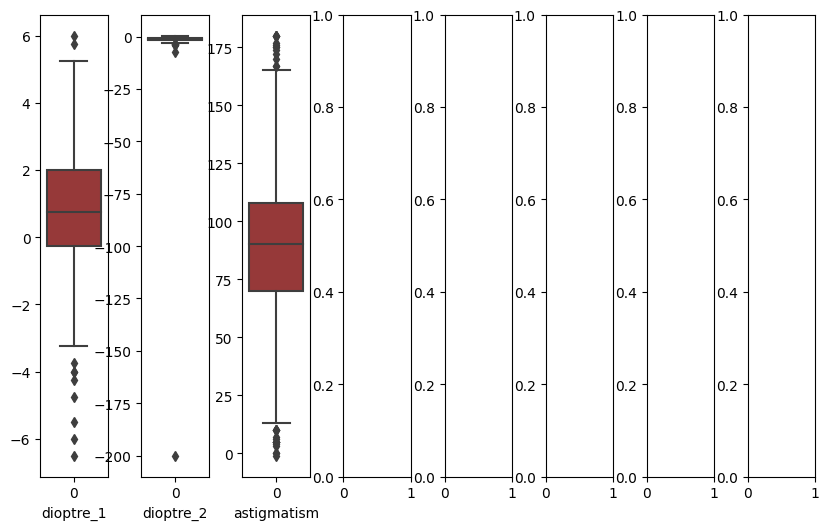

In [63]:
def box_plot_columns(df,ids):
    
    fig, ax = plt.subplots(1, len(ids), figsize=(10, 6))
    plt.subplots_adjust(wspace=0.5) 
    for i in range(len(ids)):
        sns.boxplot(data=df[ids[i]], ax=ax[i],color='brown',)
        ax[i].set_xlabel(ids[i])


box_plot_columns(od, ['dioptre_1', 'dioptre_2','astigmatism', 'Pneumatic', 'Perkins',
       'Pachymetry', 'Axial_Length', 'VF_MD'])

ValueError: could not convert string to float: 'the eye keeps the lens'

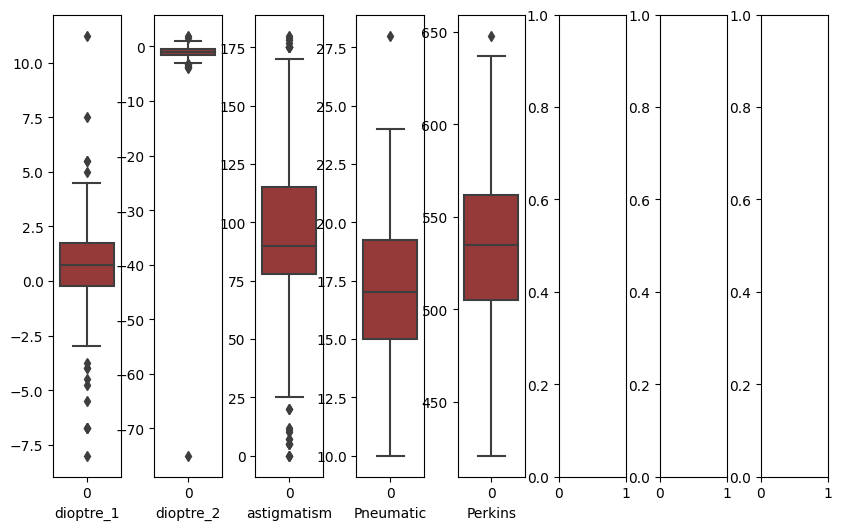

In [ ]:
box_plot_columns(os, ['dioptre_1', 'dioptre_2','astigmatism', 'Pneumatic', 'Perkins',
       'Pachymetry', 'Axial_Length', 'VF_MD'])

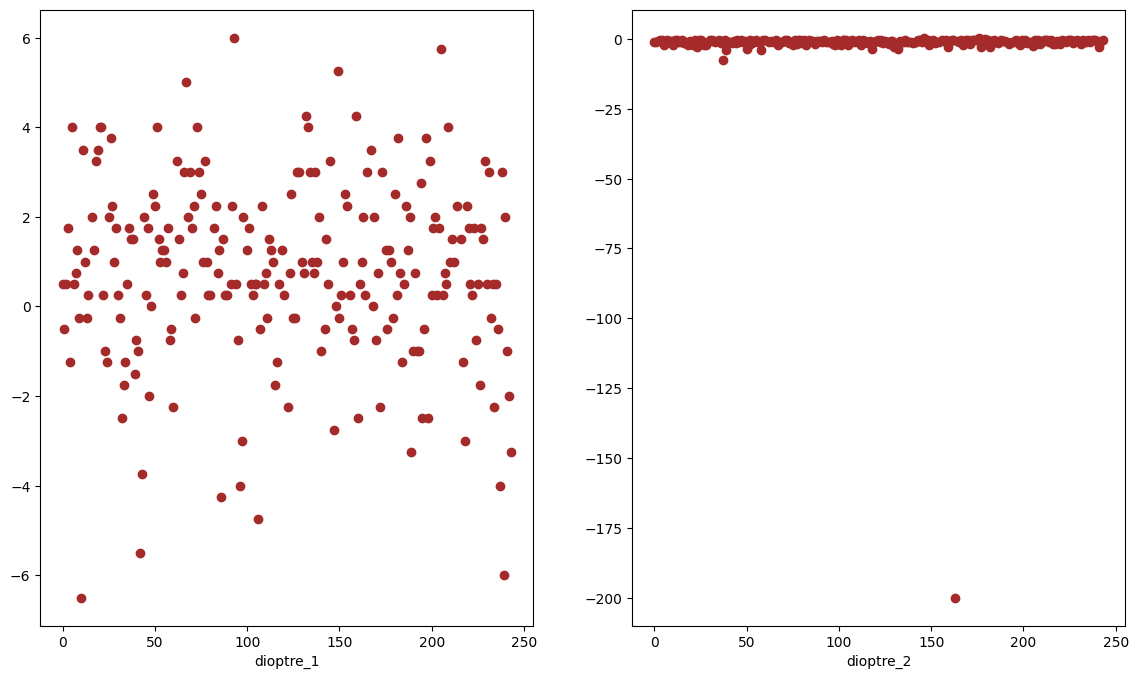

In [ ]:
def scatter_plot_columns(df,ids):
    x=np.arange(0,len(df[ids[0]]))
    if(len(ids)==1):
        plt.scatter( x=x ,y=df[ids[0]], color='brown',)
        plt.show()
        return
    fig, ax = plt.subplots(1, len(ids), figsize=(14, 8))
    
    for i in range(len(ids)):
        ax[i].scatter( x=x ,y=df[ids[i]], color='brown',)
        ax[i].set_xlabel(ids[i])


scatter_plot_columns(od, ['dioptre_1','dioptre_2'])

#scatter_plot_columns(os, ['dioptre_1','dioptre_2'])

this value of -200 in dioptre_2 is a clear outlier and will be removed now so the data analysis can be done with more accuracy

In [ ]:
od['dioptre_2'].replace(-200, np.nan, inplace=True)

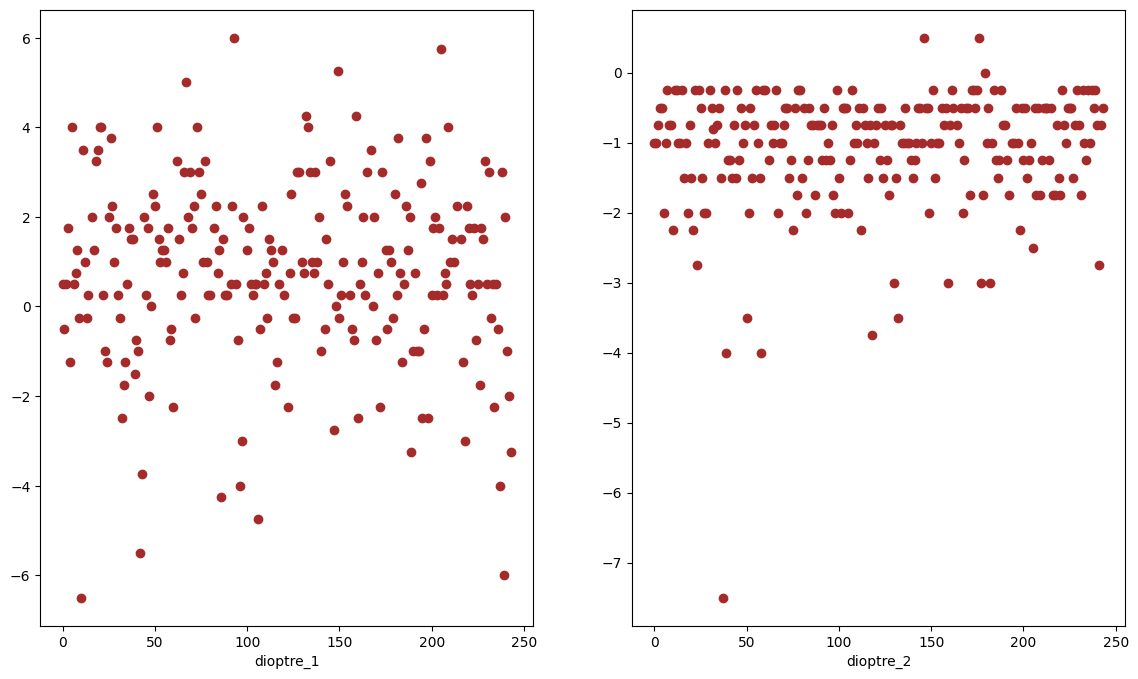

In [ ]:
scatter_plot_columns(od, ['dioptre_1','dioptre_2'])

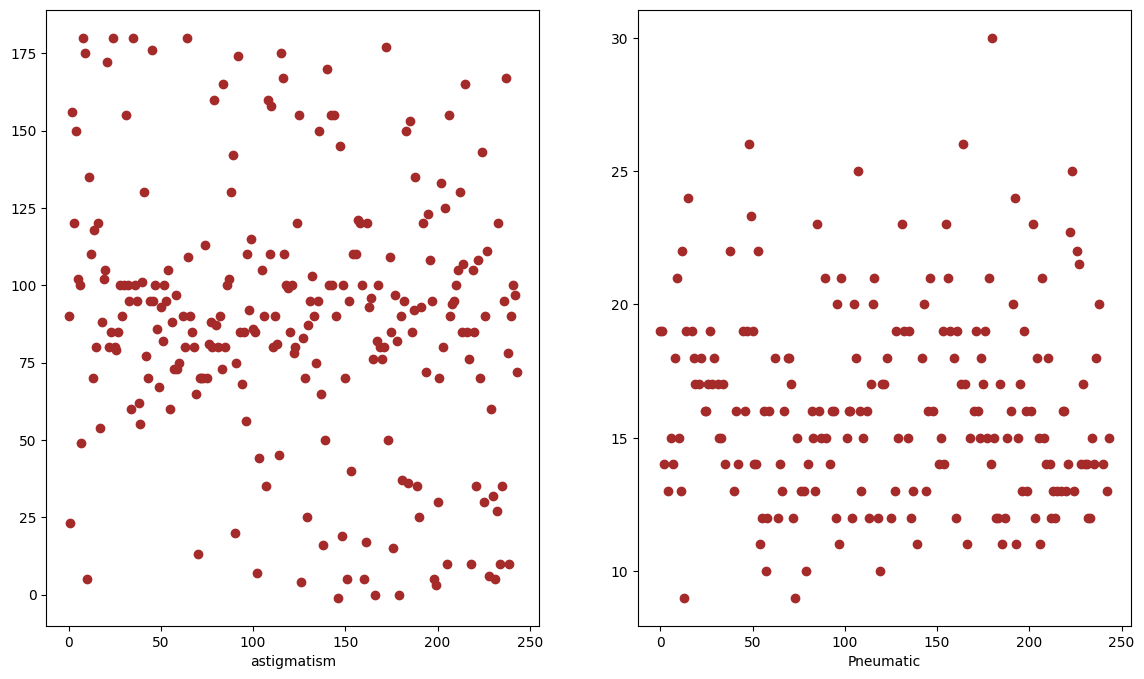

In [ ]:
scatter_plot_columns(od, ['astigmatism', 'Pneumatic'])

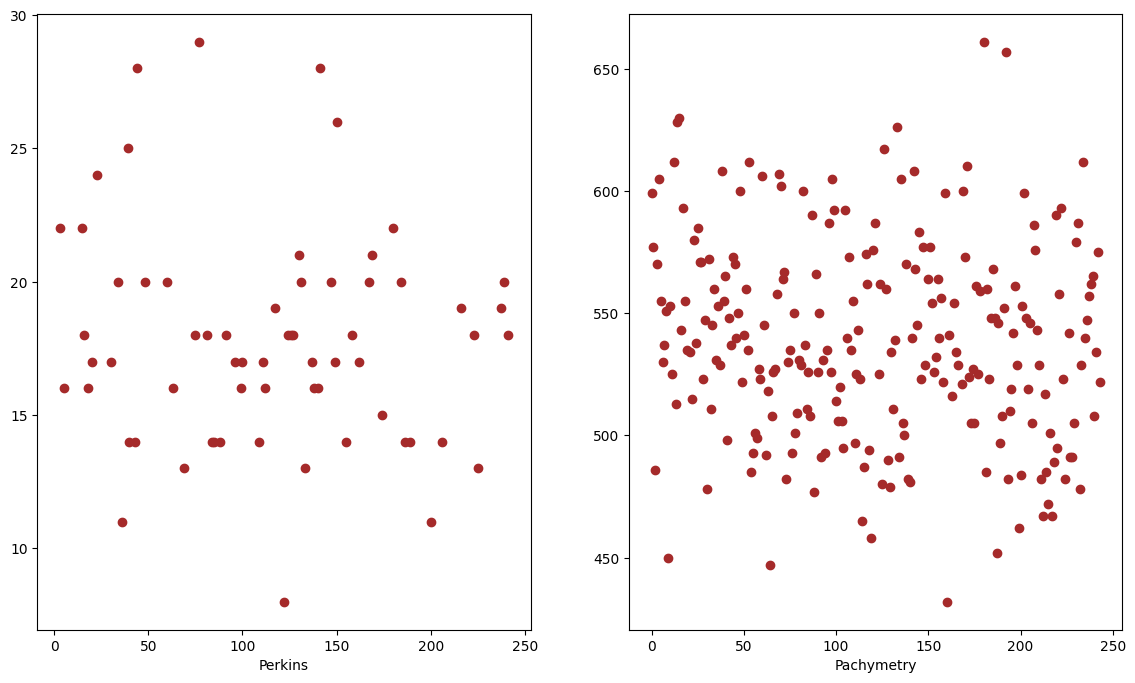

In [ ]:
scatter_plot_columns(od, ['Perkins','Pachymetry'])

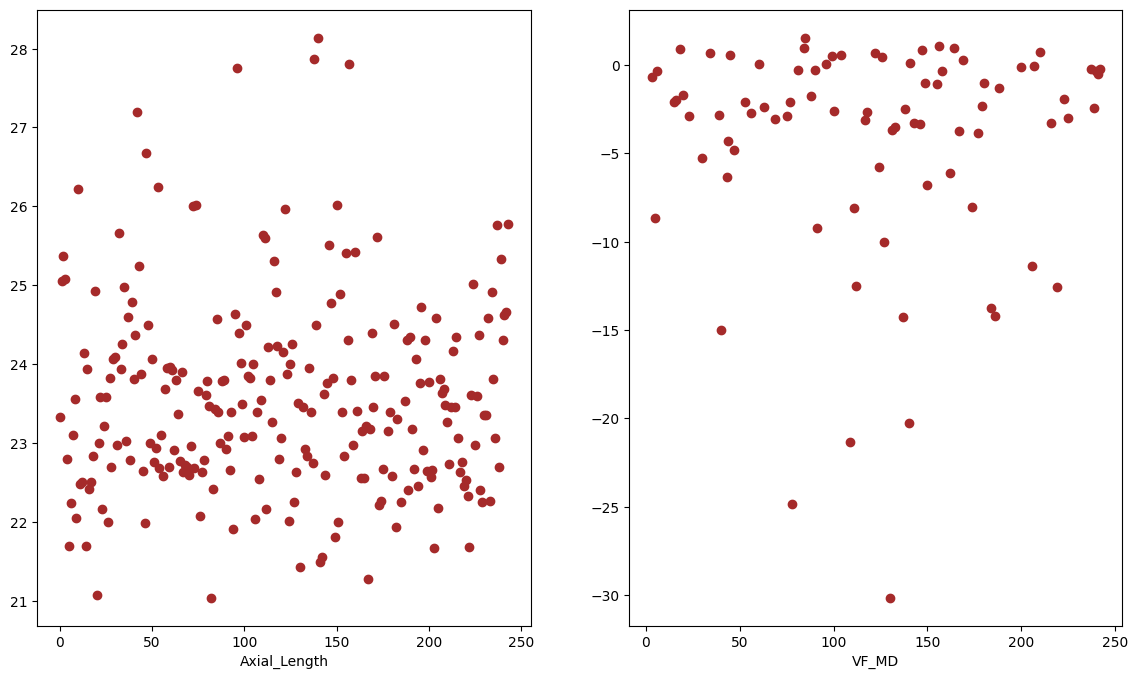

In [ ]:
scatter_plot_columns(od, ['Axial_Length', 'VF_MD'])

Now we will use histograms to show the distribution and see if any of the columns have a normal distribution 


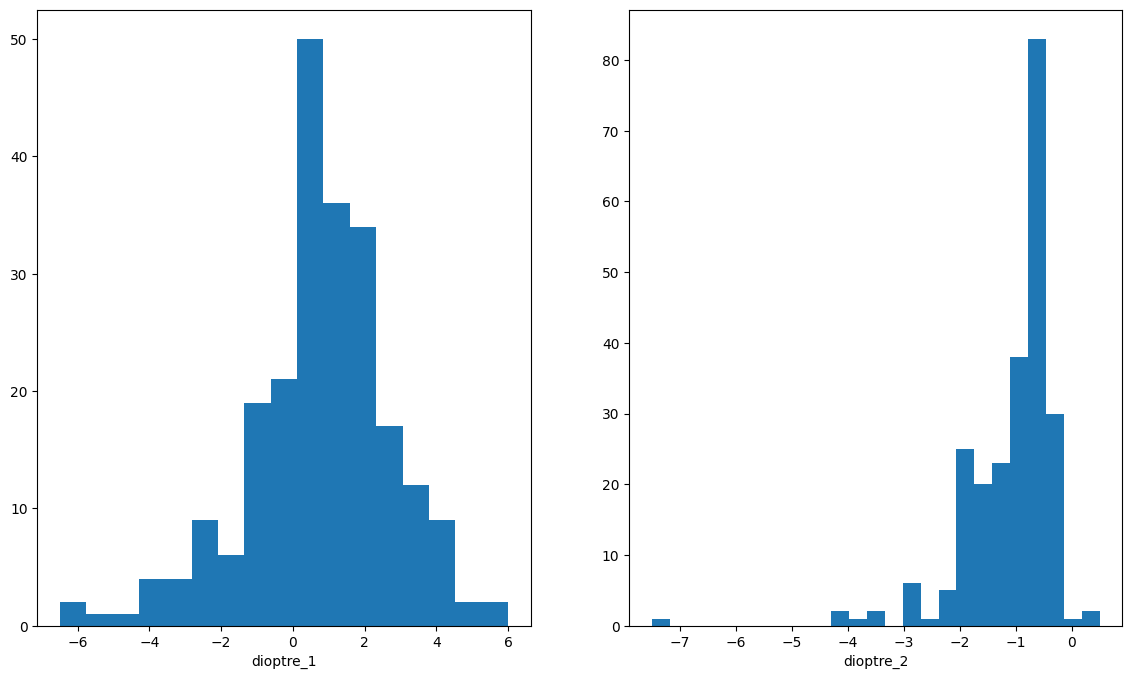

In [ ]:
def histogram_for_columns(df, ids):
    if len(ids)==1:
        plt.hist(df[ids[0]], bins='auto')
        
        plt.show()
        return
    fig, ax = plt.subplots(1, len(ids), figsize=(14, 8))
    
    for i in range(len(ids)):
        ax[i].hist(df[ids[i]], bins='auto')
        ax[i].set_xlabel(ids[i])

histogram_for_columns(od, ['dioptre_1','dioptre_2'])

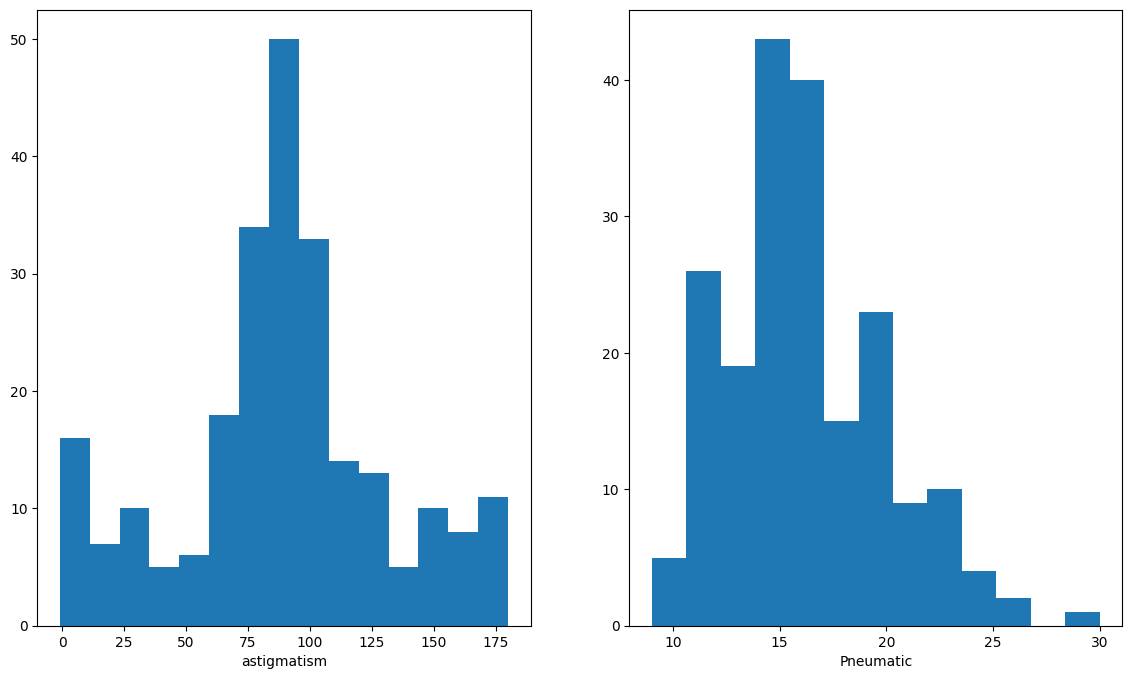

In [ ]:
histogram_for_columns(od, ['astigmatism', 'Pneumatic'])

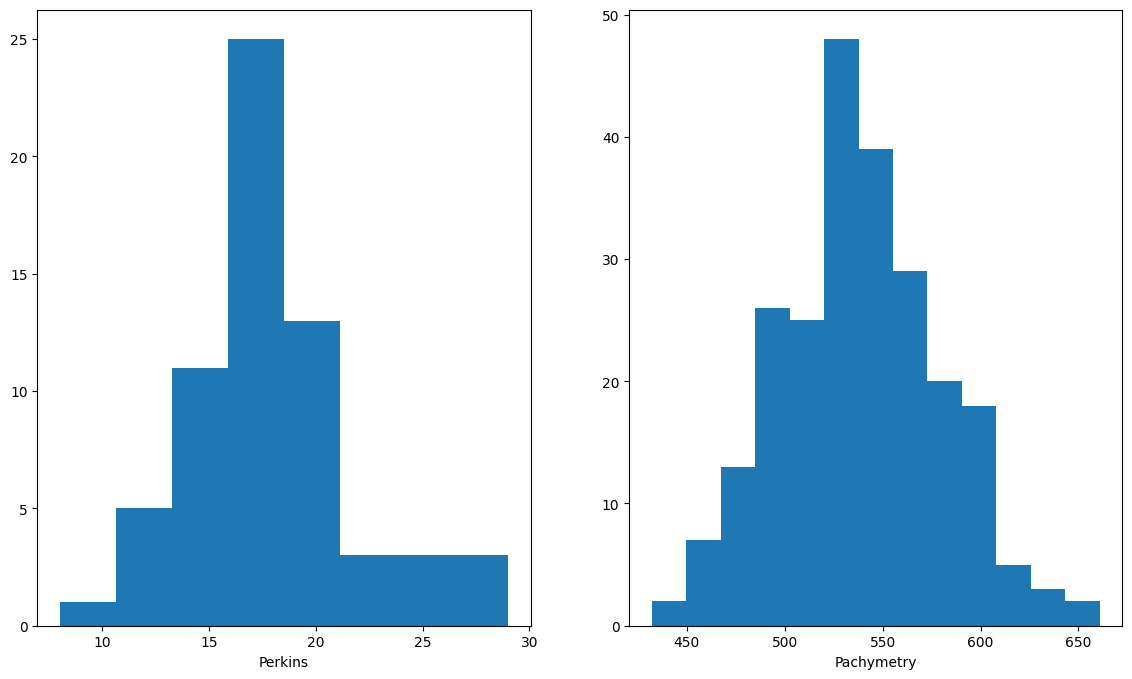

In [ ]:
histogram_for_columns(od, ['Perkins','Pachymetry'])

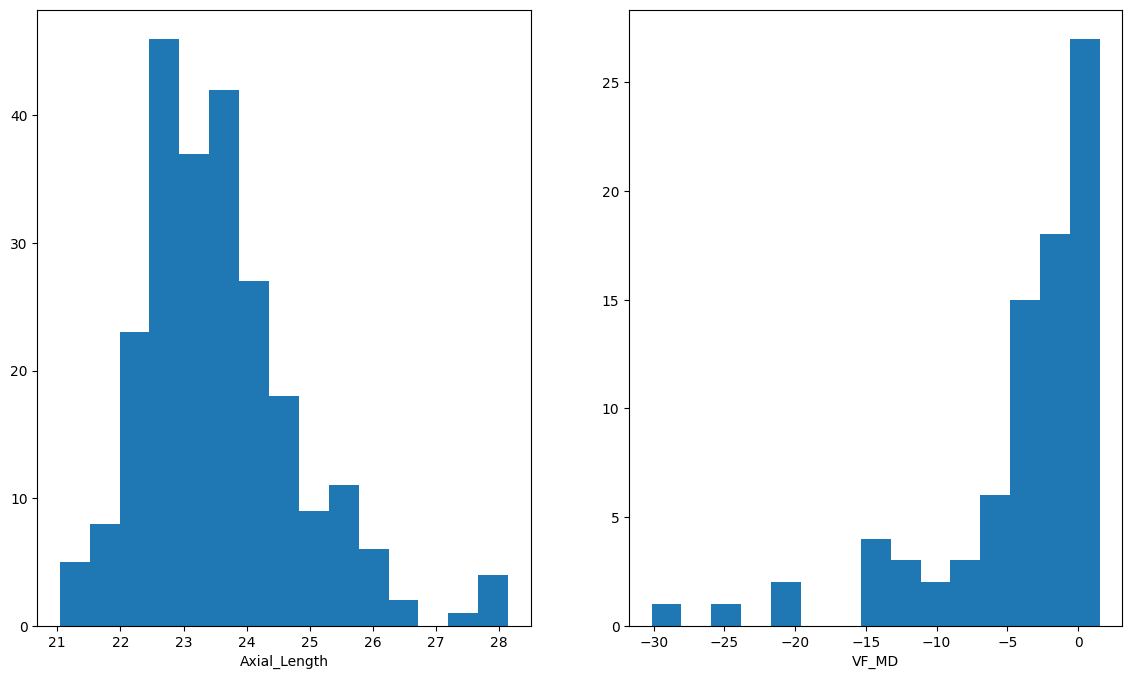

In [ ]:
histogram_for_columns(od, ['Axial_Length', 'VF_MD'])

as we can see some of these have normal distributions we will use the interquartile ranges to remove outliers from the columns let's confirm these are normally distributed with the pandas.skew()

In [ ]:
for i in ['Pachymetry','Perkins', 'astigmatism', 'dioptre_1']:
    print(f'skew of {i} is {od[i].skew()}')

skew of Pachymetry is 0.17552035854868572
skew of Perkins is 0.6444499170784165
skew of astigmatism is -0.030395542138215725
skew of dioptre_1 is -0.5535115947042473


this confirms pchymetry and astigmatism are normally distributed without skew

Now we will check for the relationships of thee data between eachother
we will do this by checking the correlation of vaariables 

1420

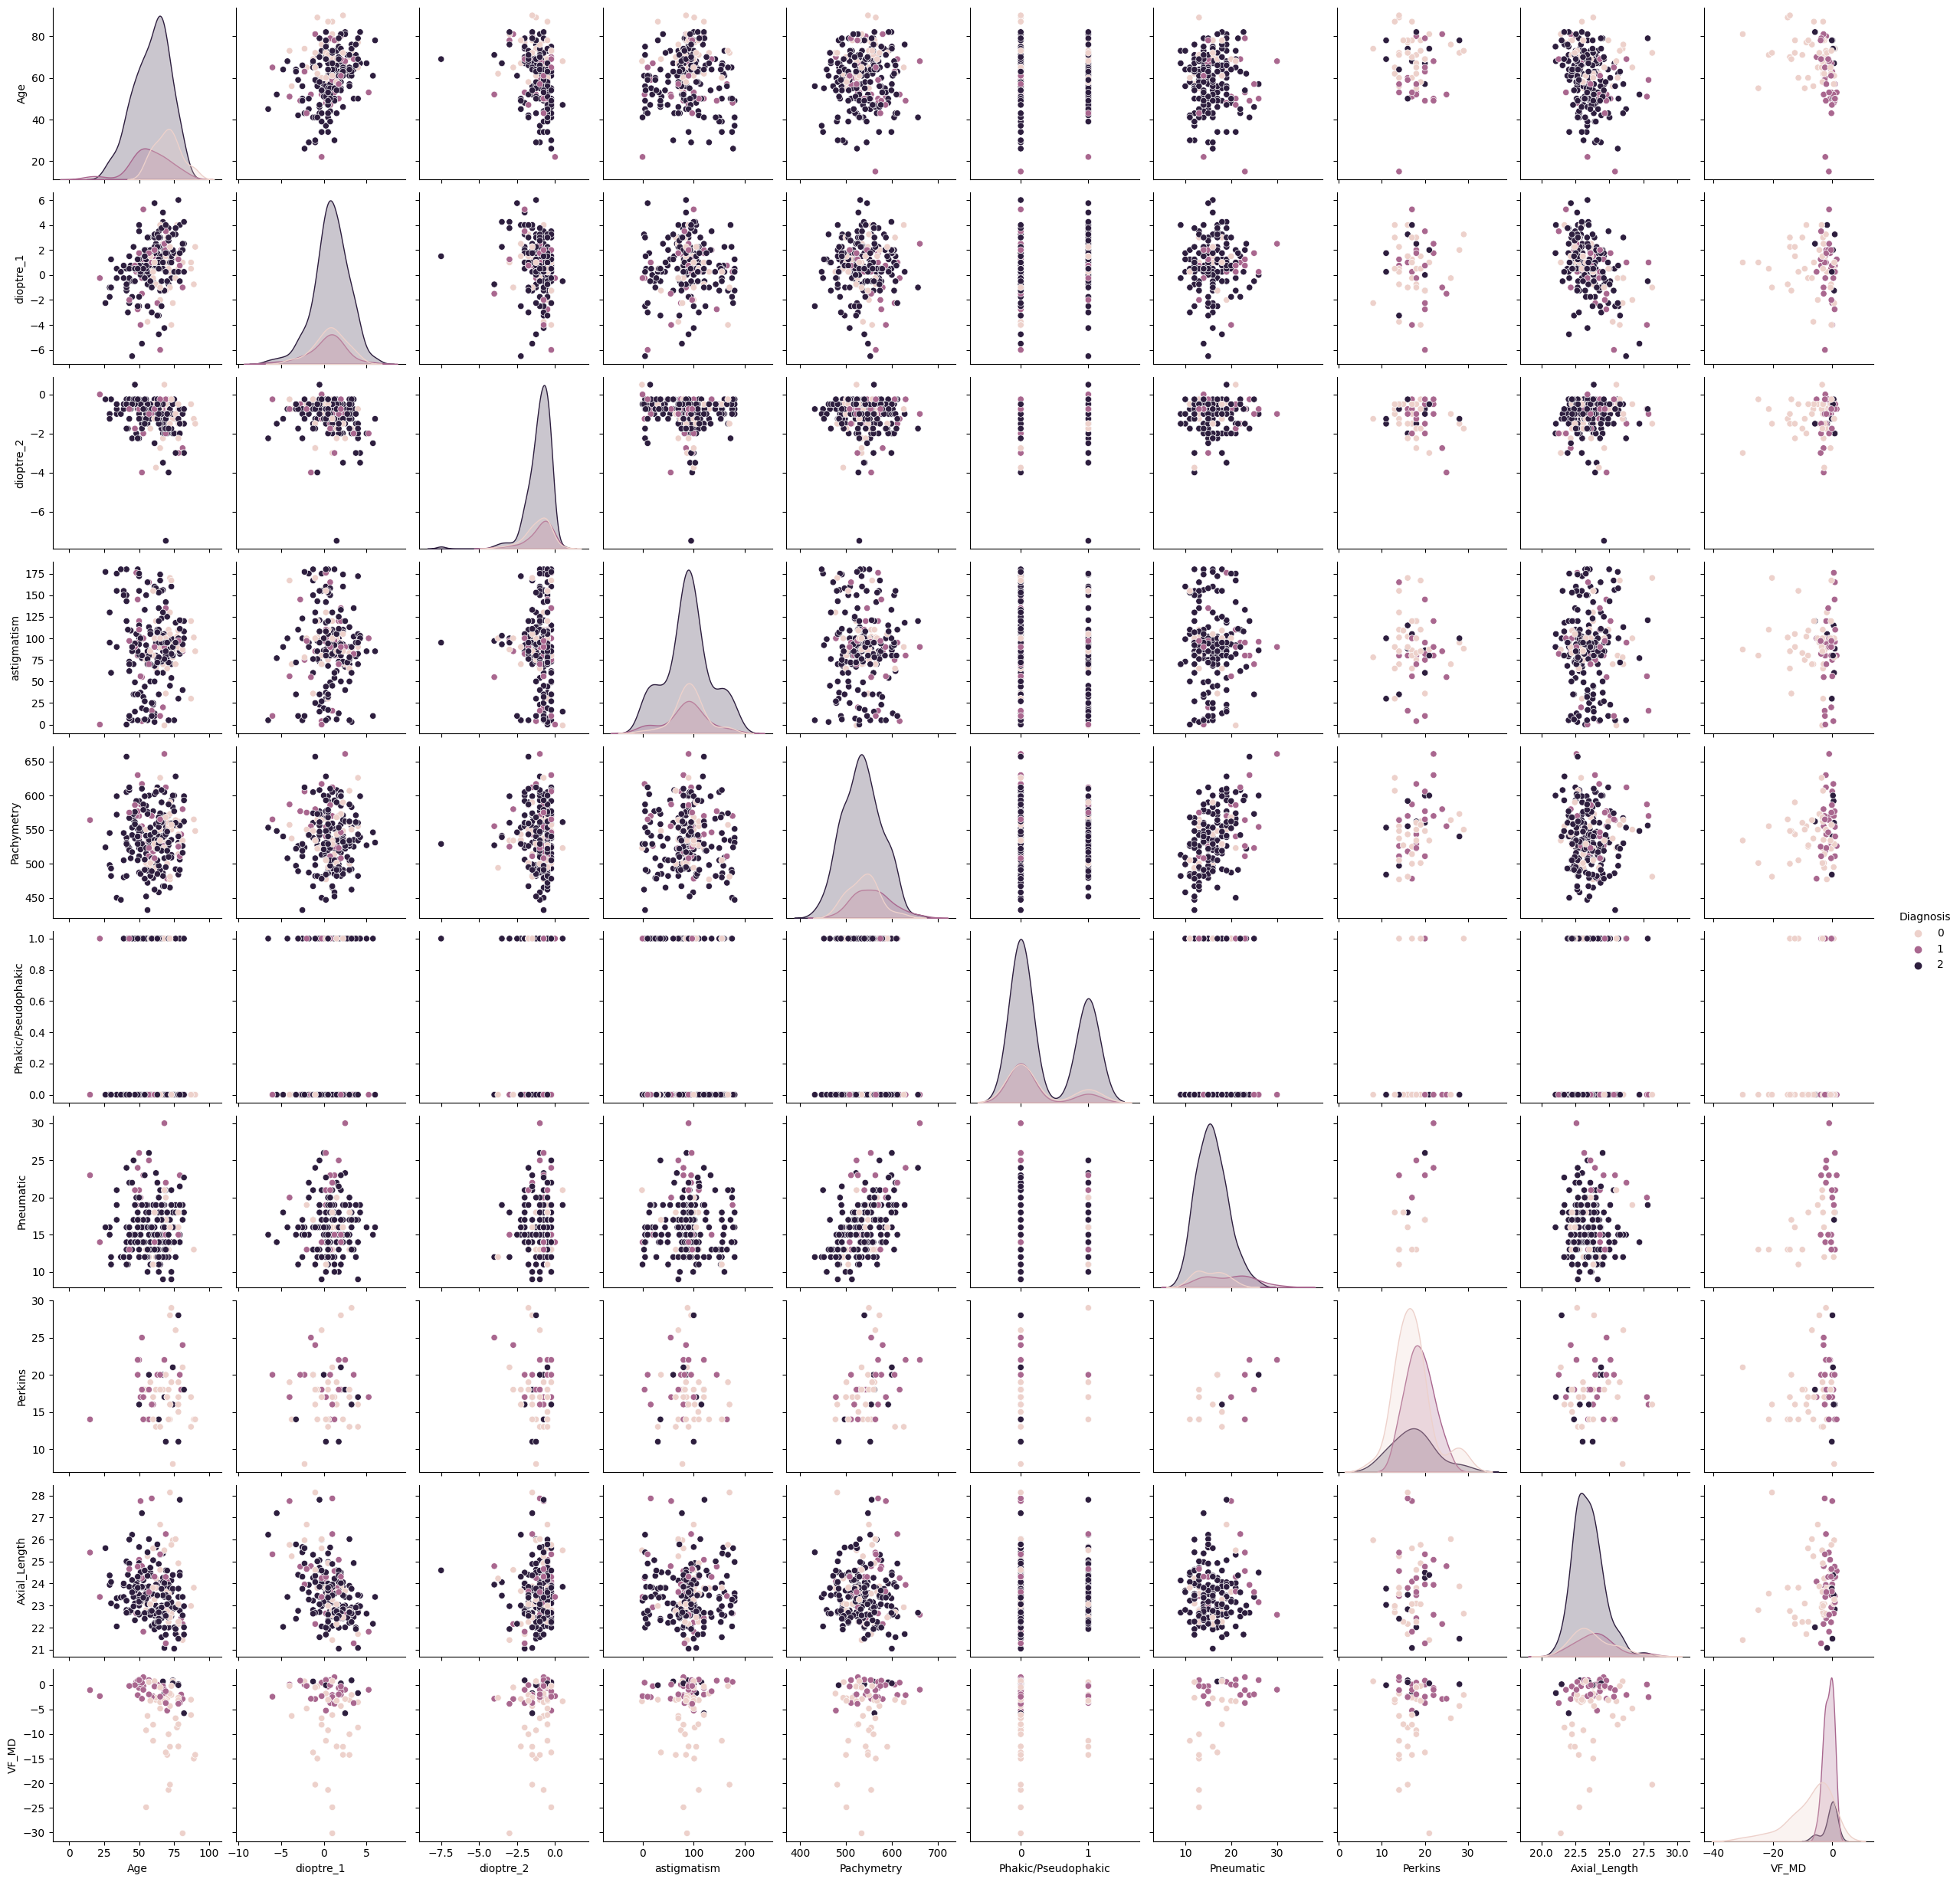

In [ ]:
sns.pairplot(od, hue="Diagnosis")
gc.collect()

<Axes: >

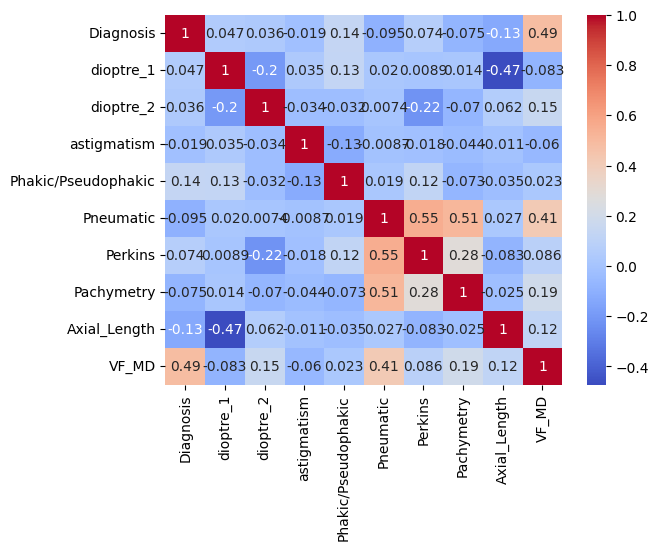

In [ ]:
sns.heatmap(od.loc[:,['Diagnosis','dioptre_1', 'dioptre_2','astigmatism','Phakic/Pseudophakic', 'Pneumatic', 'Perkins',
       'Pachymetry', 'Axial_Length', 'VF_MD']].corr(), annot= True, cmap= 'coolwarm')

no real correlation with a slight negative with axial length and dioptre_1 and a slight positive with pneumatic and VF_MD, pachymetric, and perkins

341265

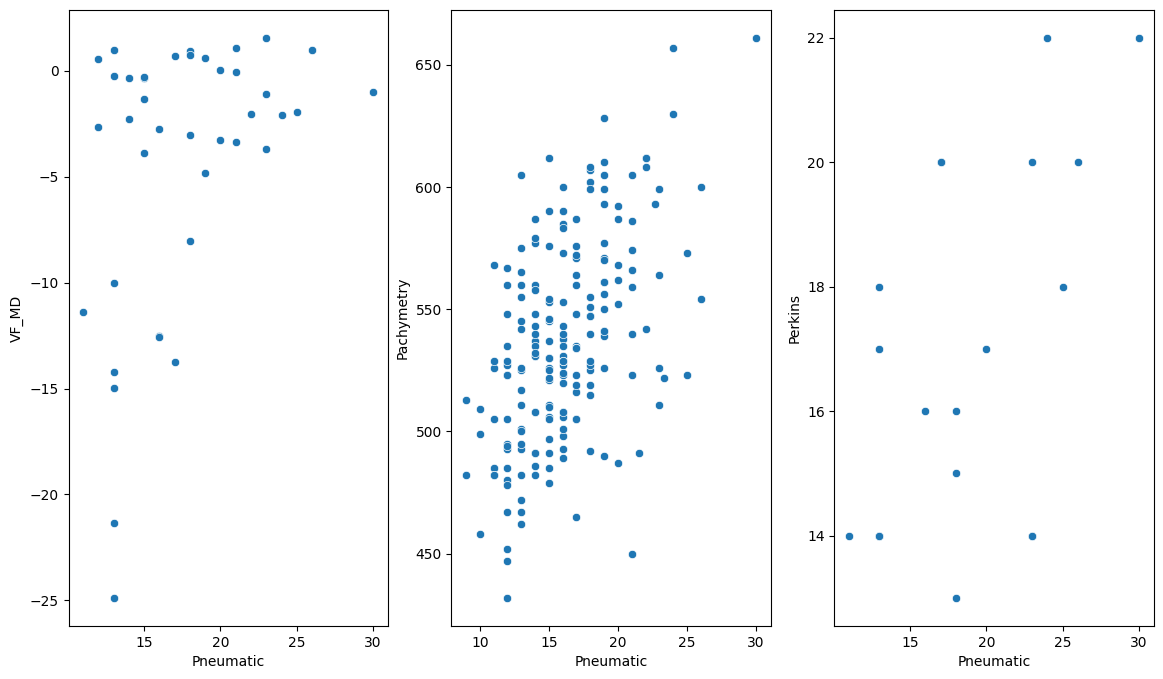

In [ ]:
ids = ['VF_MD', 'Pachymetry', 'Perkins']
x=np.arange(0,len(od[ids[0]]))
fig, ax = plt.subplots(1, len(ids), figsize=(14, 8))

for i in range(len(ids)):
    sns.scatterplot(od, x= 'Pneumatic', y=ids[i], ax=ax[i])
    

gc.collect()


167

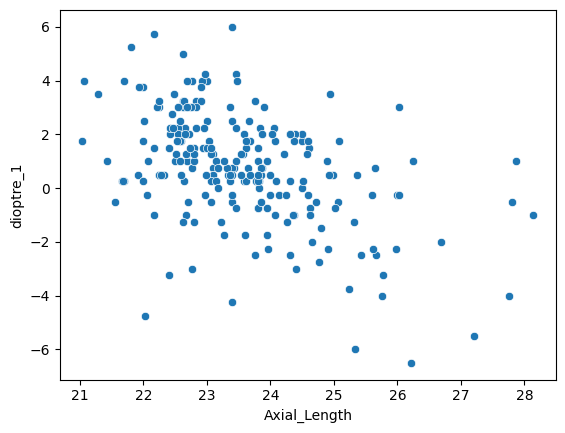

In [ ]:
sns.scatterplot(od, x= 'Axial_Length', y='dioptre_1')
gc.collect()

3770

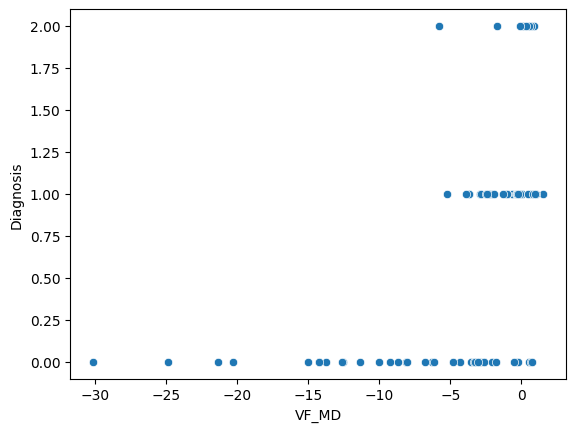

In [ ]:
sns.scatterplot(od, x='VF_MD', y='Diagnosis')
gc.collect()

as we can see there is no real correlation with variables

as pneumatics and perkins are both measures of the same thing. they also have a sleight correlation of 0.55

------------------------------------------------Missing Completely At Random Checks-----------------------------------

here we need to check if the values that have been removed from the dataset's are missing completely at random so that we can descide on which methods we will use to replace missing values in the datasets


In [ ]:
def mcar_test_(df):
    # select column of interest
    for i in df.columns:

        col = df[i]

        # check if column is MCAR
        missing_mask = col.isna()
        prop_missing = missing_mask.sum() / len(col)
        if prop_missing == np.mean(missing_mask):
            print(f'The column {i} is MCAR.')
        else:
            print(f'The column {i} is not MCAR.')
mcar_test_(od)
gc.collect()

The column ID is MCAR.
The column Age is MCAR.
The column Gender is MCAR.
The column Diagnosis is MCAR.
The column dioptre_1 is MCAR.
The column dioptre_2 is MCAR.
The column astigmatism is MCAR.
The column Pachymetry is MCAR.
The column Phakic/Pseudophakic is MCAR.
The column Pneumatic is MCAR.
The column Perkins is MCAR.
The column Axial_Length is MCAR.
The column VF_MD is MCAR.


3745

----------------------------------------------------outlier detection techniques-------------------------------------------------

detect with the inter quartile ranges and then replace the data with NAN

In [ ]:
missing_data_counter(od)
def detect_outliers (df,ids):
    for id in ids:

        Q1 = df[id].quantile(0.25)
        Q3 = df[id].quantile(0.75)
        IQR = Q3 - Q1
        #as this is a small dataset and we don't want to remove too many values we will increase the IQR multiplier to make the outlier ranges more leanient
        outliers = df[id][(df[id] < Q1 - 2.5*IQR) | (df[id] > Q3 + 2.5*IQR)]
        for i in outliers:
            
            df[id].replace(i, np.nan, inplace=True)

detect_outliers(od, ['dioptre_1', 'dioptre_2', 'Pneumatic',
        'Axial_Length'])
missing_data_counter(od)
gc.collect()

ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 6.147540983606557
dioptre_2's percentage of missing values is: 1.639344262295082
astigmatism's percentage of missing values is: 1.639344262295082
Pachymetry's percentage of missing values is: 2.8688524590163933
Phakic/Pseudophakic's percentage of missing values is: 2.0491803278688523
Pneumatic's percentage of missing values is: 19.262295081967213
Perkins's percentage of missing values is: 73.77049180327869
Axial_Length's percentage of missing values is: 2.0491803278688523
VF_MD's percentage of missing values is: 66.39344262295081



ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 6.967213114

0

as we can see astigmatism and pachymetry are normally distributed.

In [ ]:
#let's make the upper and lower limits of the Z-score anything outside of these ranges will be removed.
def Z_score_outlier_removal(df,id):
    upper_limit = df[id].mean() + 3*df[id].std()
    lower_limit = df[id].mean() - 3*df[id].std()
    print(f'upper limit is {upper_limit}')
    print(f'lower limit is {lower_limit}')
    outliers = df[id][(df[id] < lower_limit) | (df[id] > upper_limit)]
    print(outliers)
    for i in outliers:
        df[id].replace(i, np.nan, inplace=True)
for i in ['astigmatism', 'Pachymetry']:
    Z_score_outlier_removal(od, i)
gc.collect()

upper limit is 214.88959062212814
lower limit is -37.21459062212814
Series([], Name: astigmatism, dtype: float64)
upper limit is 661.670549858498
lower limit is 415.62902820057377
Series([], Name: Pachymetry, dtype: float64)


0

As we ccan see from Z score neither of these distributions have outliers


-------------------------------------------------filling in missing variables-----------------------------------------------

let's start with out MCAR columns here we can use mean imputation to fill in the values as they are missing completely at random however looking at the histogram's we will need to use mode and median values as they have skews

In [ ]:
missing_data_counter(od)
def normal_mcar_fill(df, ids):
    for i in ids:
        df[i].fillna(df[i].mean(), inplace=True)

normal_mcar_fill(od, ['astigmatism', 'Pachymetry'])
missing_data_counter(od)
gc.collect()

ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 6.967213114754098
dioptre_2's percentage of missing values is: 2.0491803278688523
astigmatism's percentage of missing values is: 1.639344262295082
Pachymetry's percentage of missing values is: 2.8688524590163933
Phakic/Pseudophakic's percentage of missing values is: 2.0491803278688523
Pneumatic's percentage of missing values is: 19.262295081967213
Perkins's percentage of missing values is: 73.77049180327869
Axial_Length's percentage of missing values is: 2.459016393442623
VF_MD's percentage of missing values is: 66.39344262295081



ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 6.967213114

0

now we will deal with the skewed data I am going to use the median as this is a better representation of the skewed data then the mean


In [ ]:
missing_data_counter(od)
def skewed_mcar_fill(df,ids):
    for i in ids:
        df[i].fillna(df[i].median(), inplace=True)
skewed_mcar_fill(od, ['dioptre_1', 'dioptre_2', 'Pneumatic', 
        'Axial_Length'])
missing_data_counter(od)
gc.collect()

ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 6.967213114754098
dioptre_2's percentage of missing values is: 2.0491803278688523
astigmatism's percentage of missing values is: 0.0
Pachymetry's percentage of missing values is: 0.0
Phakic/Pseudophakic's percentage of missing values is: 2.0491803278688523
Pneumatic's percentage of missing values is: 19.262295081967213
Perkins's percentage of missing values is: 73.77049180327869
Axial_Length's percentage of missing values is: 2.459016393442623
VF_MD's percentage of missing values is: 66.39344262295081



ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 0.0
dioptre_2's percentage of missing va

0

as Phakic/pseudophakic has a missing value % that is quite low and it is a discrete variable we will use the most common imputation to fill in the missing values

In [ ]:
def mode_missing_data_fill(df, id):
    df[id].fillna(df[id].mode, inplace=True)

mode_missing_data_fill(od, 'Phakic/Pseudophakic')
missing_data_counter(od)
gc.collect()

ID's percentage of missing values is: 0.0
Age's percentage of missing values is: 0.0
Gender's percentage of missing values is: 0.0
Diagnosis's percentage of missing values is: 0.0
dioptre_1's percentage of missing values is: 0.0
dioptre_2's percentage of missing values is: 0.0
astigmatism's percentage of missing values is: 0.0
Pachymetry's percentage of missing values is: 0.0
Phakic/Pseudophakic's percentage of missing values is: 0.0
Pneumatic's percentage of missing values is: 0.0
Perkins's percentage of missing values is: 73.77049180327869
Axial_Length's percentage of missing values is: 0.0
VF_MD's percentage of missing values is: 66.39344262295081





0

dropping high missing value items


In [ ]:

print(od.columns)
od.drop('VF_MD', axis= 1)

Index(['ID', 'Age', 'Gender', 'Diagnosis', 'dioptre_1', 'dioptre_2',
       'astigmatism', 'Pachymetry', 'Phakic/Pseudophakic', 'Pneumatic',
       'Perkins', 'Axial_Length', 'VF_MD'],
      dtype='object')


: 

: 